In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

In [ ]:
pd.set_option('display.max_columns', 500)
train = pd.read_csv("/content/train.csv")
# train.head()

In [ ]:
test = pd.read_csv("/content/test.csv")

In [ ]:
X = pd.concat([train, test])
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

In [ ]:
X = X[['Timestamp','Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift','tv delta']]

In [ ]:
X = X[X['Timestamp'] != '2012-09-20 04:00:00+00:00']
X = X[X['Timestamp'] != '2012-09-20 05:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 09:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 10:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 11:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 12:00:00+00:00']

In [ ]:
df = X.copy()
df['month'] = df['Timestamp'].dt.month
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['hour'] = df['Timestamp'].dt.hour
df = df.set_index('Timestamp')
df.sort_index(inplace=True)

X = df[['Temperature', 'holiday', 'prev value', 'twice prev value', 'day shift',
       'month shift', 'month', 'day_of_week', 'hour']]
y = df['tv delta']

In [ ]:
X_train = X[:30000]
X_test = X[30000:40000]
y_train = y[:30000]
y_test = y[30000:40000]
X_validate = X[40000:]
y_validate = y[40000:]
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_test.shape}
    holdout  (rows, cols) = {X_validate.shape}""")

Shape of the datasets:
    training (rows, cols) = (30000, 9)
    validate (rows, cols) = (10000, 9)
    holdout  (rows, cols) = (8995, 9)


In [ ]:
# Mahalanobis Distance
def mahalanobis_distance(x, mean_vector, cov_matrix):
    delta = x - mean_vector
    mahalanobis_dist = np.sqrt(np.dot(delta, np.dot(np.linalg.inv(cov_matrix), delta.T)))
    return mahalanobis_dist

# Train the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
train_data = lgb.Dataset(X_train, label=y_train)
bst = lgb.train(params, train_data, num_boost_round=100)

train_pred = bst.predict(X_train)
# predictions on the test data
test_pred = bst.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 9
[LightGBM] [Info] Start training from score 137.998656


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_train, train_pred)

# Calculate MAE
mae = mean_absolute_error(y_train, train_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 169.40608525990206
Mean Absolute Error (MAE): 9.342361095111961


In [ ]:
# Mahalanobis distance for each predicted value
mean_vector = X_test.mean(axis=0)
cov_matrix = np.cov(X_test, rowvar=False)
mahalanobis_distances = []
for point in test_pred:
    mahalanobis_distances.append(mahalanobis_distance(point, mean_vector, cov_matrix))

# threshold for anomaly detection
threshold = np.percentile(mahalanobis_distances, 95)

# Identify anomalies based on the Mahalanobis distance exceeding the threshold
anomalies = (mahalanobis_distances > threshold).astype(int)
date_indices = X_test.index


Number of anomalies: 500


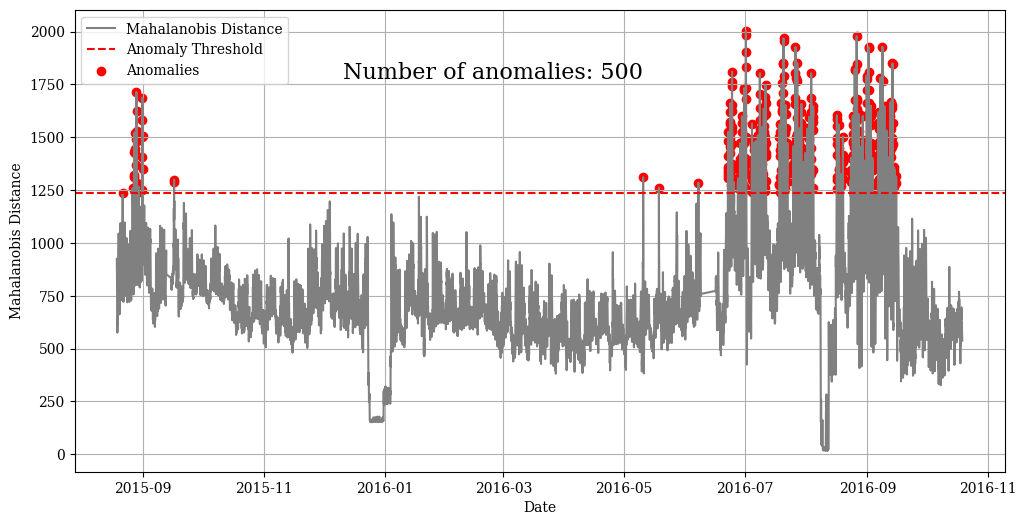

In [ ]:
# Plot Mahalanobis distances
plt.figure(figsize=(12, 6))
plt.plot(date_indices, mahalanobis_distances, label='Mahalanobis Distance', color='gray')

# Plot the threshold
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')

# Mark anomaly points
anomaly_indices = np.where(anomalies == 1)[0]
plt.scatter(date_indices[anomaly_indices], [mahalanobis_distances[i] for i in anomaly_indices], color='red', label='Anomalies')

# Count the number of anomalies
num_anomalies = np.sum(mahalanobis_distances > threshold)
print("Number of anomalies:", num_anomalies)

plt.annotate(f'Number of anomalies: {num_anomalies}', xy=(0.45, 0.85), xycoords='axes fraction', ha='center', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Mahalanobis Distance')
# plt.title('Anomaly Detection using Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()


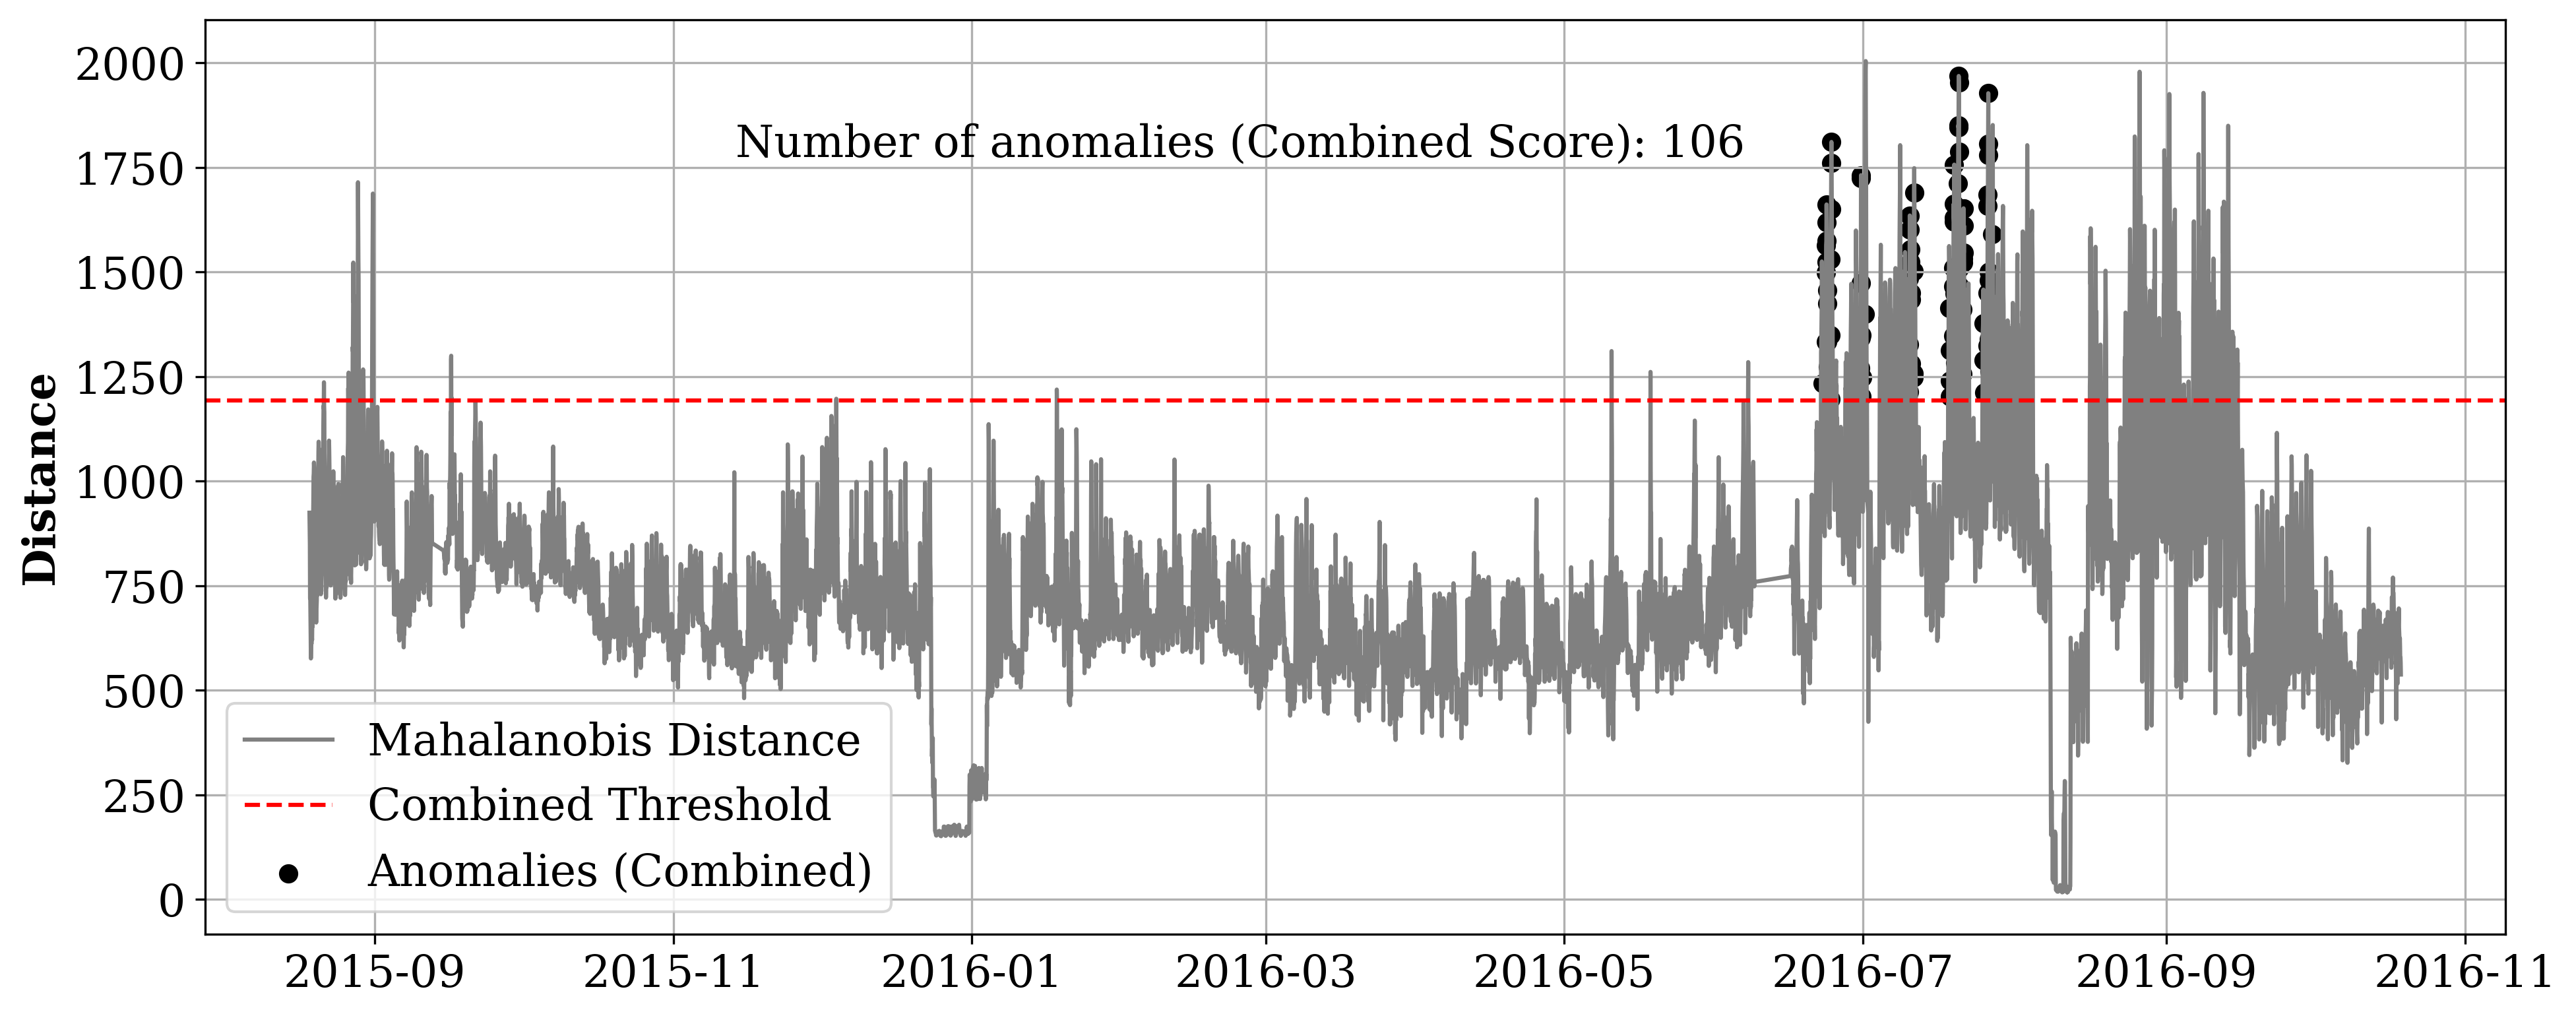

In [ ]:
# moving averages of Mahalanobis distances
window_size = 24
moving_avg_distances = np.convolve(mahalanobis_distances, np.ones(window_size)/window_size, mode='valid')

# Set dynamic thresholds
mahalanobis_threshold = np.percentile(mahalanobis_distances, 95)
moving_avg_threshold = np.percentile(moving_avg_distances, 95)

# Combine Mahalanobis distance and moving averages to determine the threshold
combined_threshold = (mahalanobis_threshold + moving_avg_threshold) / 2

min_length = min(len(mahalanobis_distances), len(moving_avg_distances))
mahalanobis_distances = mahalanobis_distances[:min_length]
moving_avg_distances = moving_avg_distances[:min_length]

# Classify anomalies
anomalies_combined = ((mahalanobis_distances > combined_threshold) & (moving_avg_distances > combined_threshold)).astype(int)

# Get date indices
date_indices = X_test.index[:min_length]

# Count number of anomalies based on combined score
num_anomalies_combined = np.sum(anomalies_combined)

# Plot Mahalanobis distances and moving averages
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(date_indices, mahalanobis_distances, label='Mahalanobis Distance', color='gray')

# Plot dynamic thresholds
plt.axhline(combined_threshold, color='red', linestyle='--', label='Combined Threshold')

# anomaly points for combined score
anomaly_indices_combined = np.where(anomalies_combined == 1)[0]
plt.scatter(date_indices[anomaly_indices_combined], [mahalanobis_distances[i] for i in anomaly_indices_combined], color='black', label='Anomalies (Combined)')

plt.legend(fontsize=16)
plt.ylabel('Distance', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.annotate(f'Number of anomalies (Combined Score): {num_anomalies_combined}', xy=(0.45, 0.85), xycoords='axes fraction', ha='center', fontsize=16)

plt.show()


Number of anomalies: 450


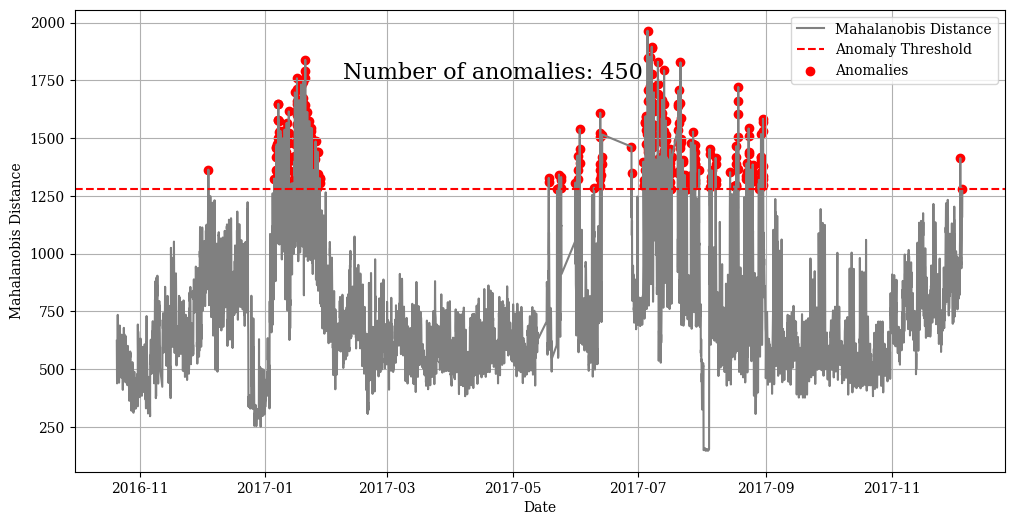

In [ ]:
# predictions on the validation data
val_pred = bst.predict(X_validate)

# Mahalanobis distance for each predicted value
mean_vector = X_validate.mean(axis=0)
cov_matrix = np.cov(X_validate, rowvar=False)
mahalanobis_distances = []
for point in val_pred:
    mahalanobis_distances.append(mahalanobis_distance(point, mean_vector, cov_matrix))

# threshold for anomaly detection
threshold = np.percentile(mahalanobis_distances, 95)  # Example: 95th percentile

# Identify anomalies based on the Mahalanobis distance exceeding the threshold
anomalies = (mahalanobis_distances > threshold).astype(int)

date_indices = X_validate.index


plt.figure(figsize=(12, 6))
plt.plot(date_indices, mahalanobis_distances, label='Mahalanobis Distance', color='gray')
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
anomaly_indices = np.where(anomalies == 1)[0]
plt.scatter(date_indices[anomaly_indices], [mahalanobis_distances[i] for i in anomaly_indices], color='red', label='Anomalies')
num_anomalies = np.sum(mahalanobis_distances > threshold)
print("Number of anomalies:", num_anomalies)

plt.annotate(f'Number of anomalies: {num_anomalies}', xy=(0.45, 0.85), xycoords='axes fraction', ha='center', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Mahalanobis Distance')
plt.title('Anomaly Detection using Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()


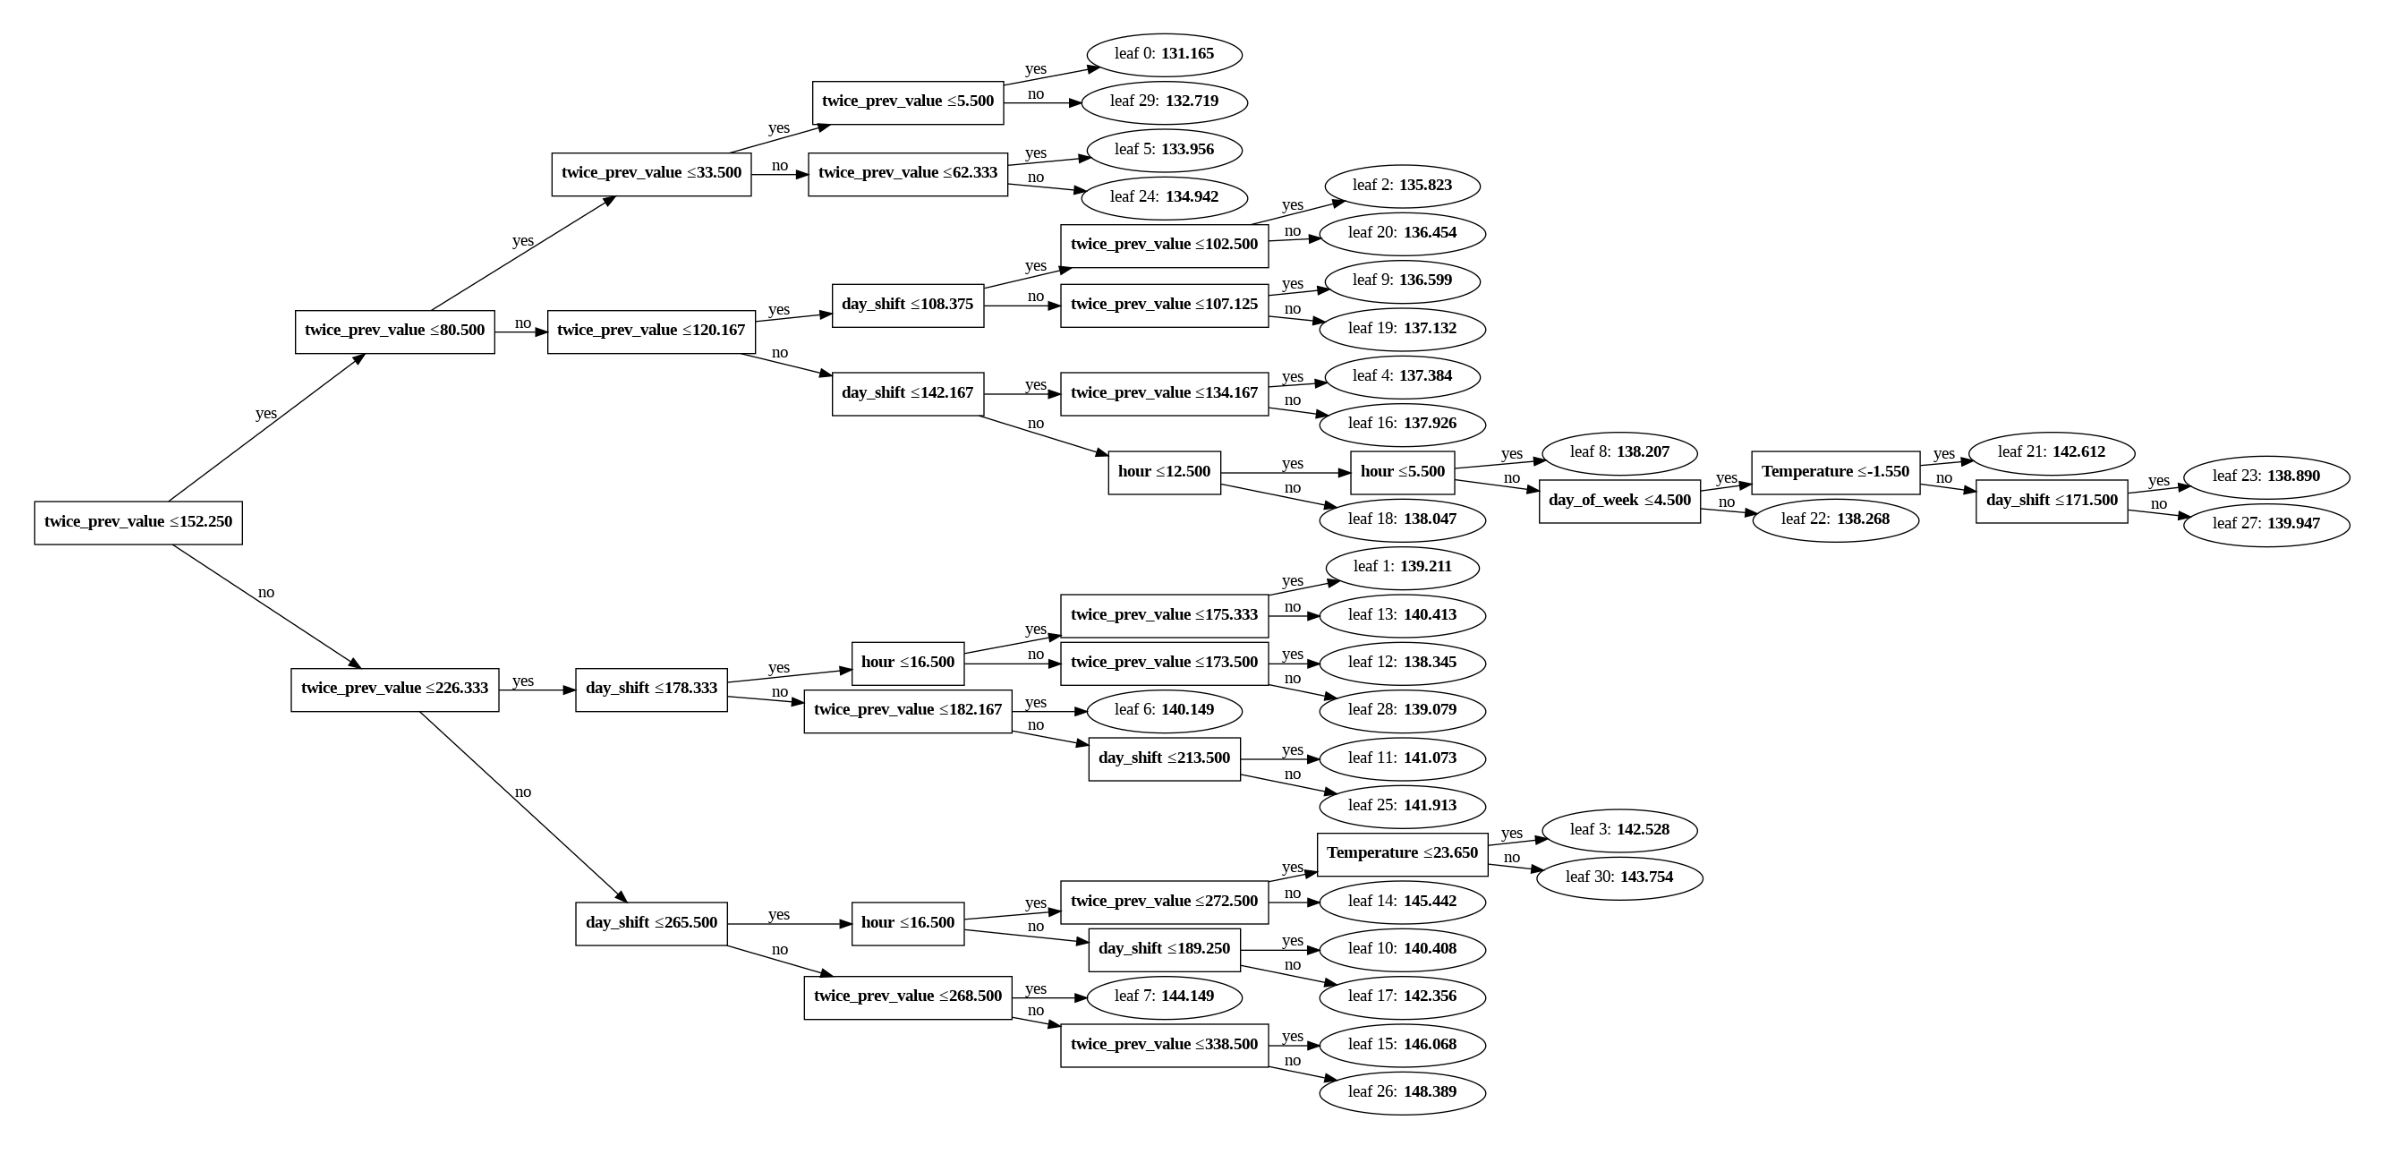

In [ ]:
import lightgbm as lgb
lgb.plot_tree(bst, tree_index=0, figsize=(10,30), dpi=300)
plt.show()

Feature Importance (%):
            Feature  Importance
2        prev_value   84.346786
3  twice_prev_value   10.688265
8              hour    1.906110
4         day_shift    1.860300
0       Temperature    0.736419
7       day_of_week    0.242519
6             month    0.156798
5       month_shift    0.062335
1           holiday    0.000468


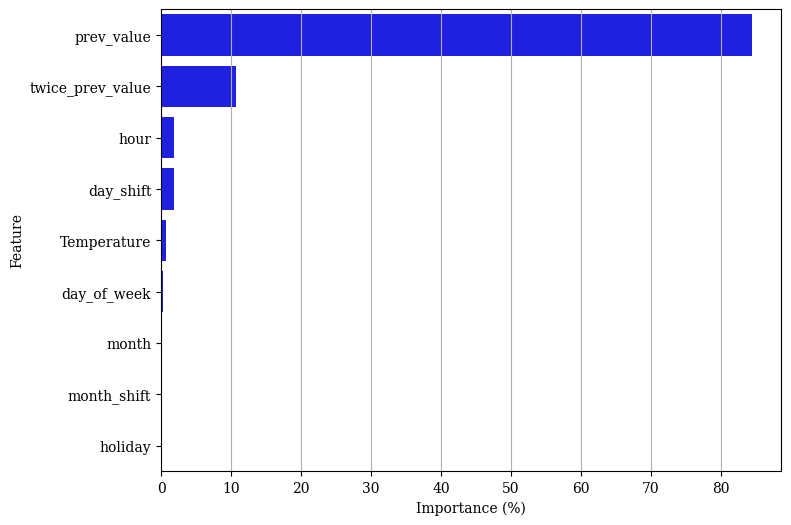

In [ ]:
import seaborn as sns
# feature importance
feature_importance = bst.feature_importance(importance_type='gain')
feature_names = bst.feature_name()

# Normalize importance values to express as a percentage
total_importance = np.sum(feature_importance)
feature_importance_percent = (feature_importance / total_importance) * 100

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_percent
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance (%):")
print(feature_importance_df)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='b')
plt.title('Feature Importance (%)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()


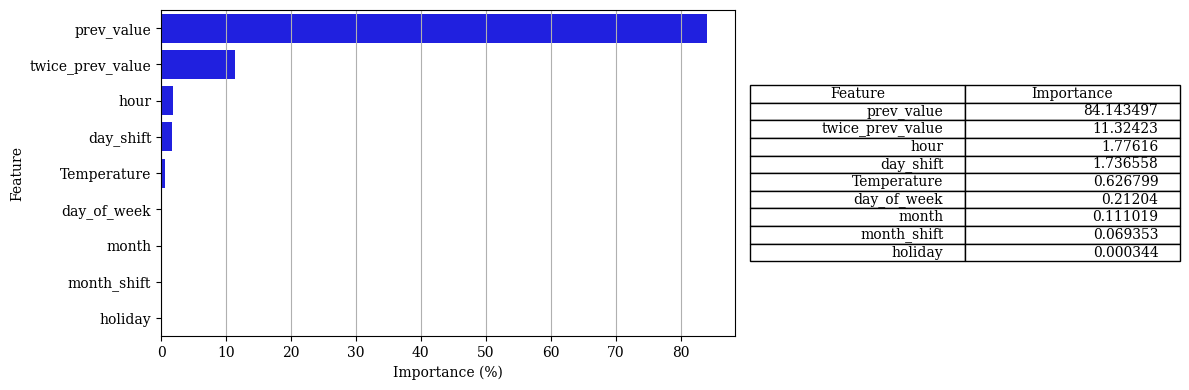

In [ ]:
data = {
    'Feature': ['prev_value', 'twice_prev_value', 'hour', 'day_shift', 'Temperature', 'day_of_week', 'month', 'month_shift', 'holiday'],
    'Importance': [84.143497, 11.324230, 1.776160, 1.736558, 0.626799, 0.212040, 0.111019, 0.069353, 0.000344]
}
feature_importance_df = pd.DataFrame(data)

plt.figure(figsize=(12, 4))
grid = plt.GridSpec(1, 2, width_ratios=[4, 3])

# bar plot
ax = plt.subplot(grid[0])
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='b', ax=ax)
ax.set_title('Feature Importance (%)')
ax.set_xlabel('Importance (%)')
ax.set_ylabel('Feature')

ax_table = plt.subplot(grid[1])
ax_table.axis('off')
tbl = ax_table.table(cellText=feature_importance_df.values,
                     colLabels=feature_importance_df.columns,
                     loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 231.2577636496587
Mean Absolute Error (MAE): 10.414455645856282


In [ ]:
import pandas as pd
import plotly.graph_objects as go

plot_data = pd.DataFrame({
    'Date': date_indices,
    'Mahalanobis Distance': mahalanobis_distances,
    'Anomaly': anomalies_combined.astype(str)
})

fig = go.Figure()

fig.add_trace(go.Scatter(x=plot_data['Date'], y=plot_data['Mahalanobis Distance'],
                         mode='lines',
                         name='Mahalanobis Distance',
                         line=dict(color='gray')))

anomaly_indices = plot_data[plot_data['Anomaly'] == '1'].index
fig.add_trace(go.Scatter(x=plot_data.iloc[anomaly_indices]['Date'],
                         y=plot_data.iloc[anomaly_indices]['Mahalanobis Distance'],
                         mode='markers',
                         name='Anomalies',
                         marker=dict(color='red', size=8)))

fig.add_shape(type="line",
              x0=plot_data['Date'].iloc[0], y0=combined_threshold,
              x1=plot_data['Date'].iloc[-1], y1=combined_threshold,
              line=dict(color="red", width=2, dash='dash'))

fig.update_layout(title='Anomaly Detection Results',
                  xaxis_title='Date',
                  yaxis_title='Mahalanobis Distance',
                  showlegend=True)
fig.show()


In [ ]:
pip install shap

100%|===================| 9970/10000 [01:00<00:00]       

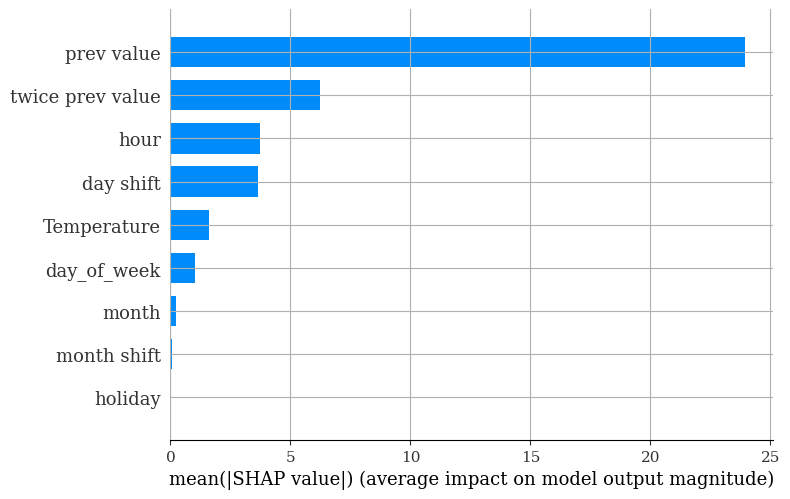

In [ ]:
import shap

explainer = shap.Explainer(bst, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
# average SHAP values of the features
average_shap_values = np.mean(shap_values, axis=0)
average_shap_values

array([ 3.73543317e-01, -1.96746807e-04, -1.07067935e+01, -2.86769939e+00,
       -1.94898578e+00, -7.44744028e-02,  2.63502359e-02,  7.73826601e-02,
        1.06595166e-01])

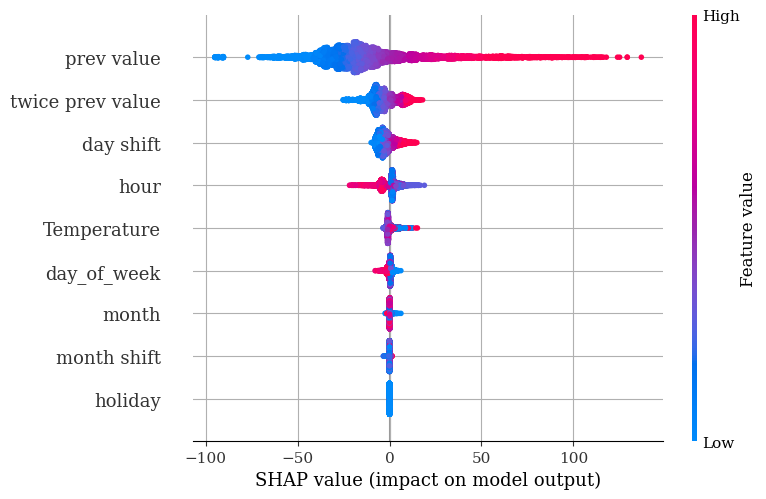

In [ ]:
# Summarize the SHAP values
shap.summary_plot(shap_values, X_test)

# eature names and values for the first instance
feature_names = X_test.columns
feature_values = X_test.iloc[0]

plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Assuming anomalies_combined is a binary array indicating anomalies
anomaly_indices = np.where(anomalies_combined == 1)[0]
anomaly_data = X_validate.iloc[anomaly_indices]

# Apply hierarchical clustering
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)  # Adjust number of clusters as needed
cluster_labels = clustering.fit_predict(anomaly_data)

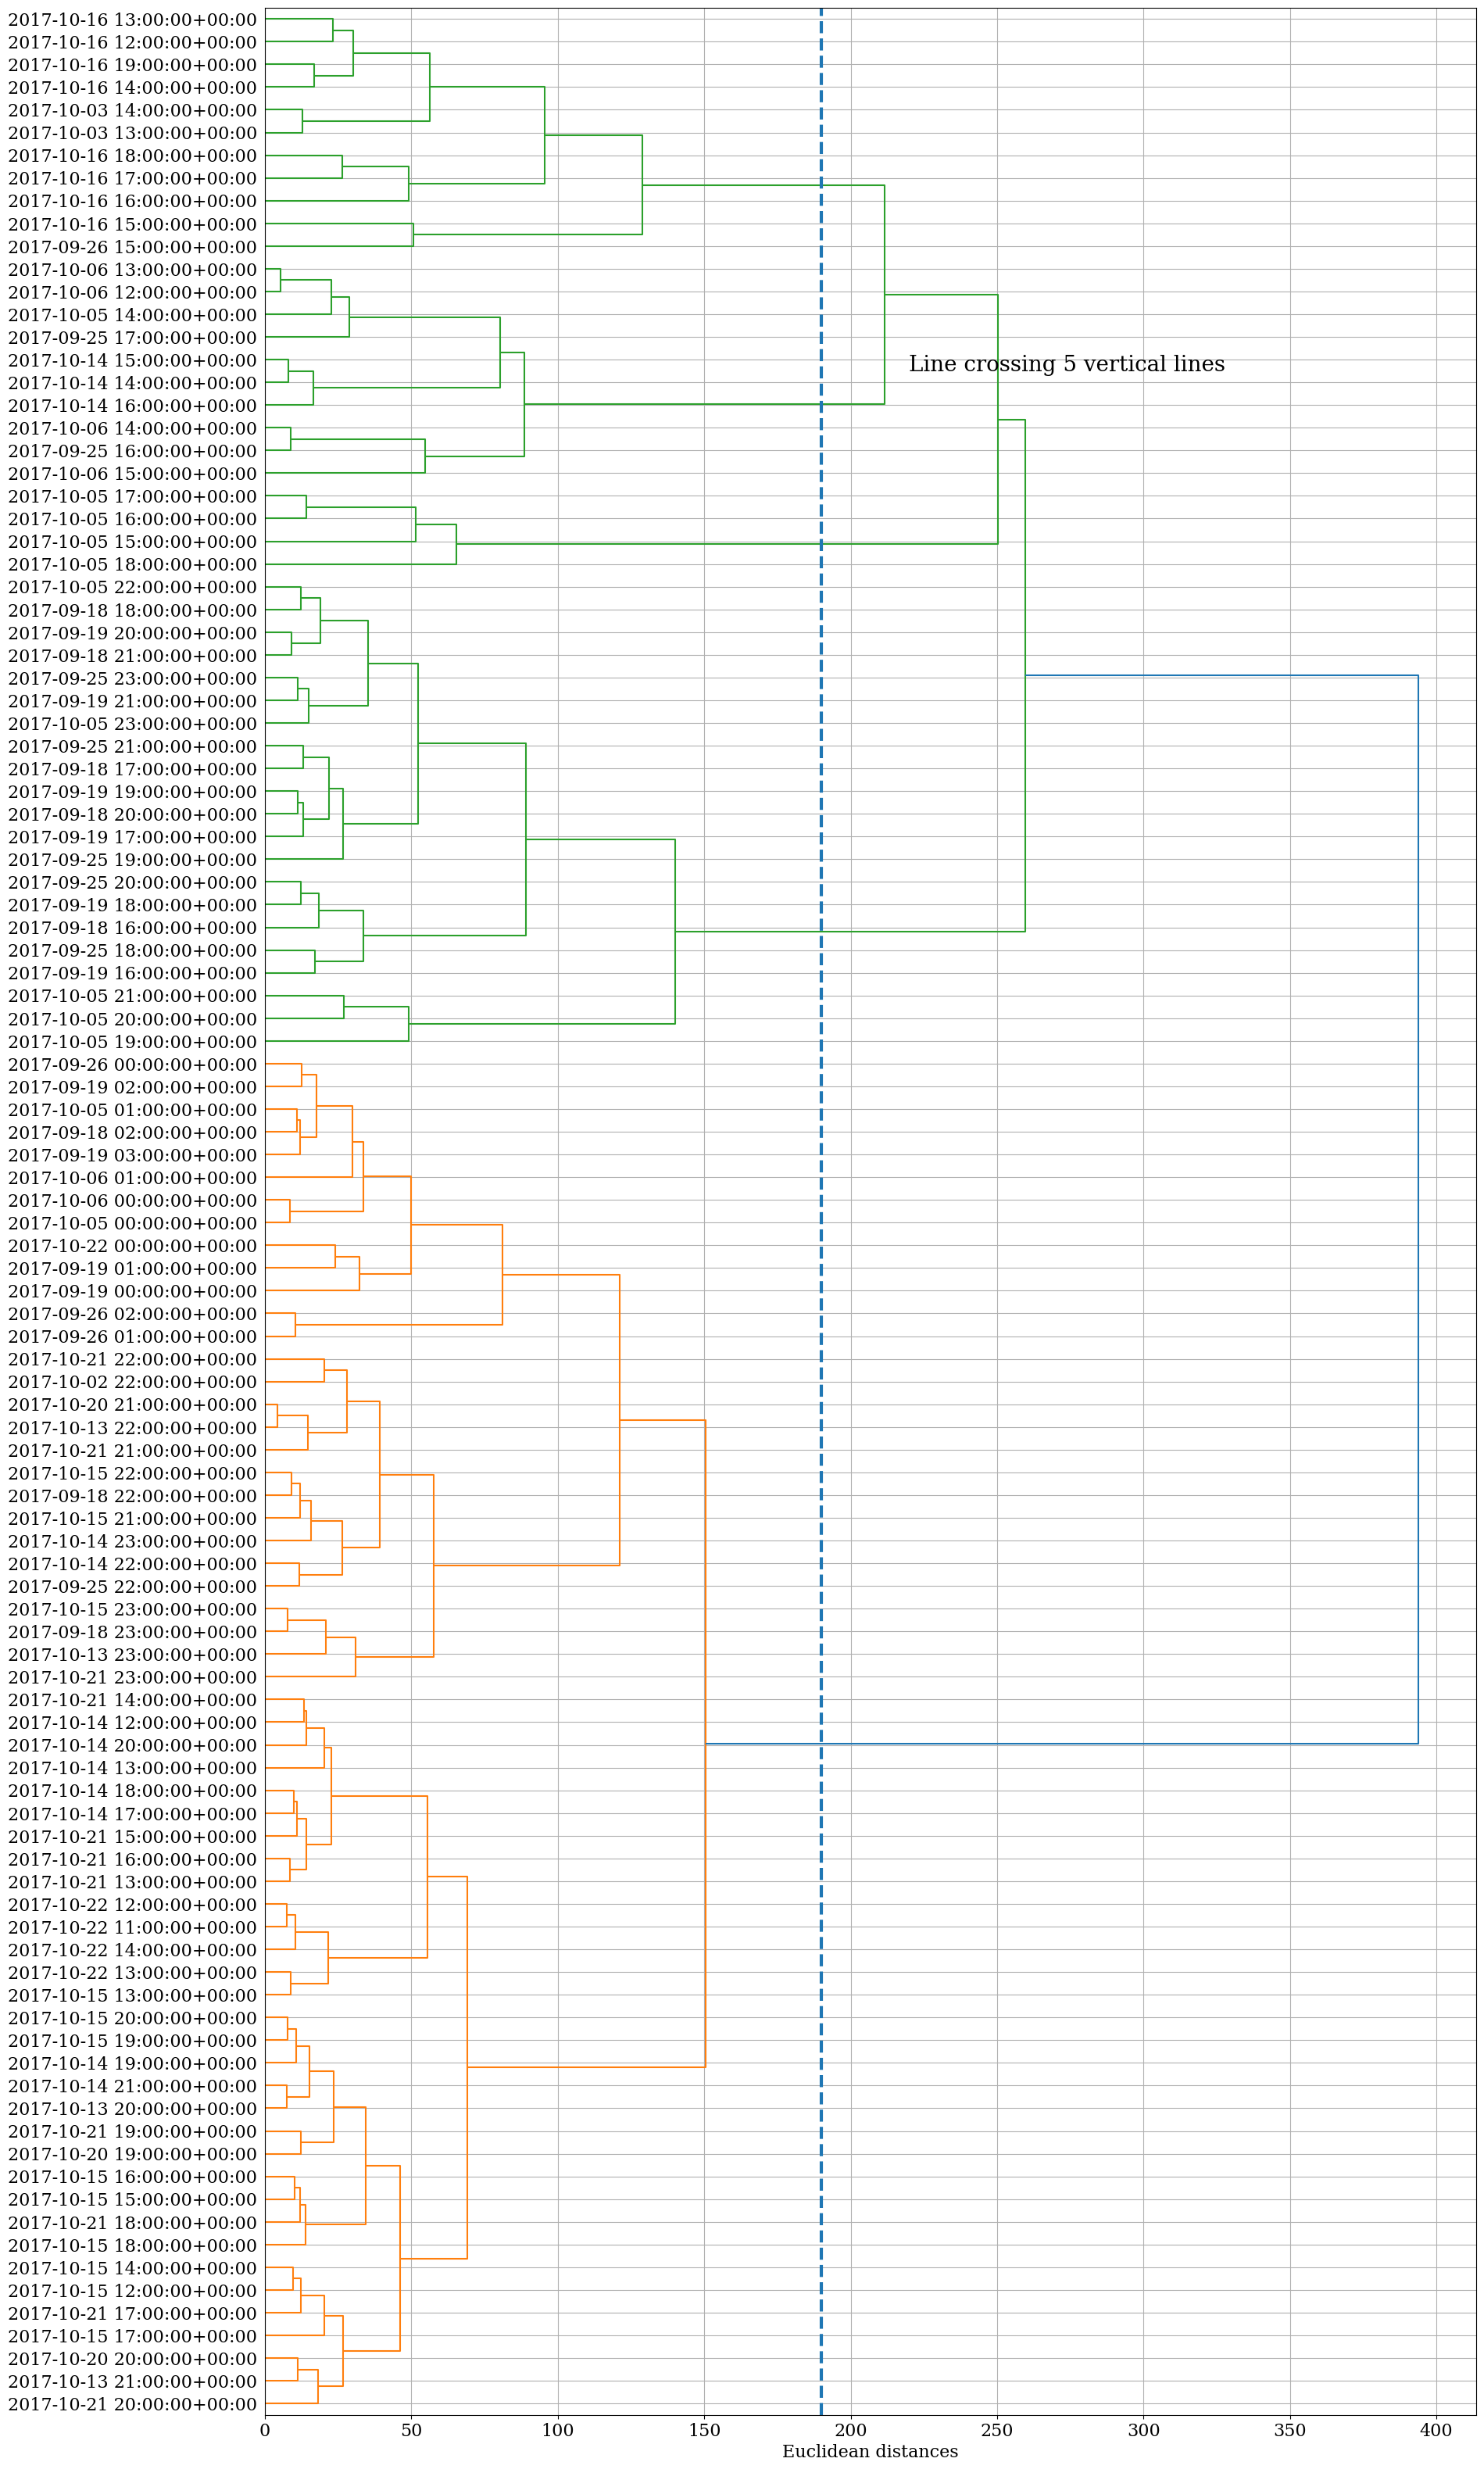

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(anomaly_data, method='ward')  # Adjust the method as needed

plt.figure(figsize=(20, 40))
dendrogram(Z, labels=anomaly_data.index, orientation='right')
# plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Euclidean distances', fontsize=16)
# plt.ylabel('Euclidean distances')
# Set font size of x-axis and y-axis tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.vlines(x=190,ymin=0,ymax=2000,lw=3,linestyles='--')
plt.text(x=220,y=900,s='Line crossing 5 vertical lines',fontsize=20)
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

silhouette_scores = []
davies_bouldin_scores = []

# Iterate over the range of number of clusters
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(anomaly_data)

    silhouette = silhouette_score(anomaly_data, cluster_labels)
    silhouette_scores.append(silhouette)

    davies_bouldin = davies_bouldin_score(anomaly_data, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin)

avg_silhouette_score = sum(silhouette_scores) / len(silhouette_scores)
avg_davies_bouldin_index = sum(davies_bouldin_scores) / len(davies_bouldin_scores)

print("Average Silhouette Score:", avg_silhouette_score)
print("Average Davies-Bouldin Index:", avg_davies_bouldin_index)


Average Silhouette Score: 0.27502325783992476
Average Davies-Bouldin Index: 1.0835770304107595


## Combining all

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Info] Start training from score 132.426469


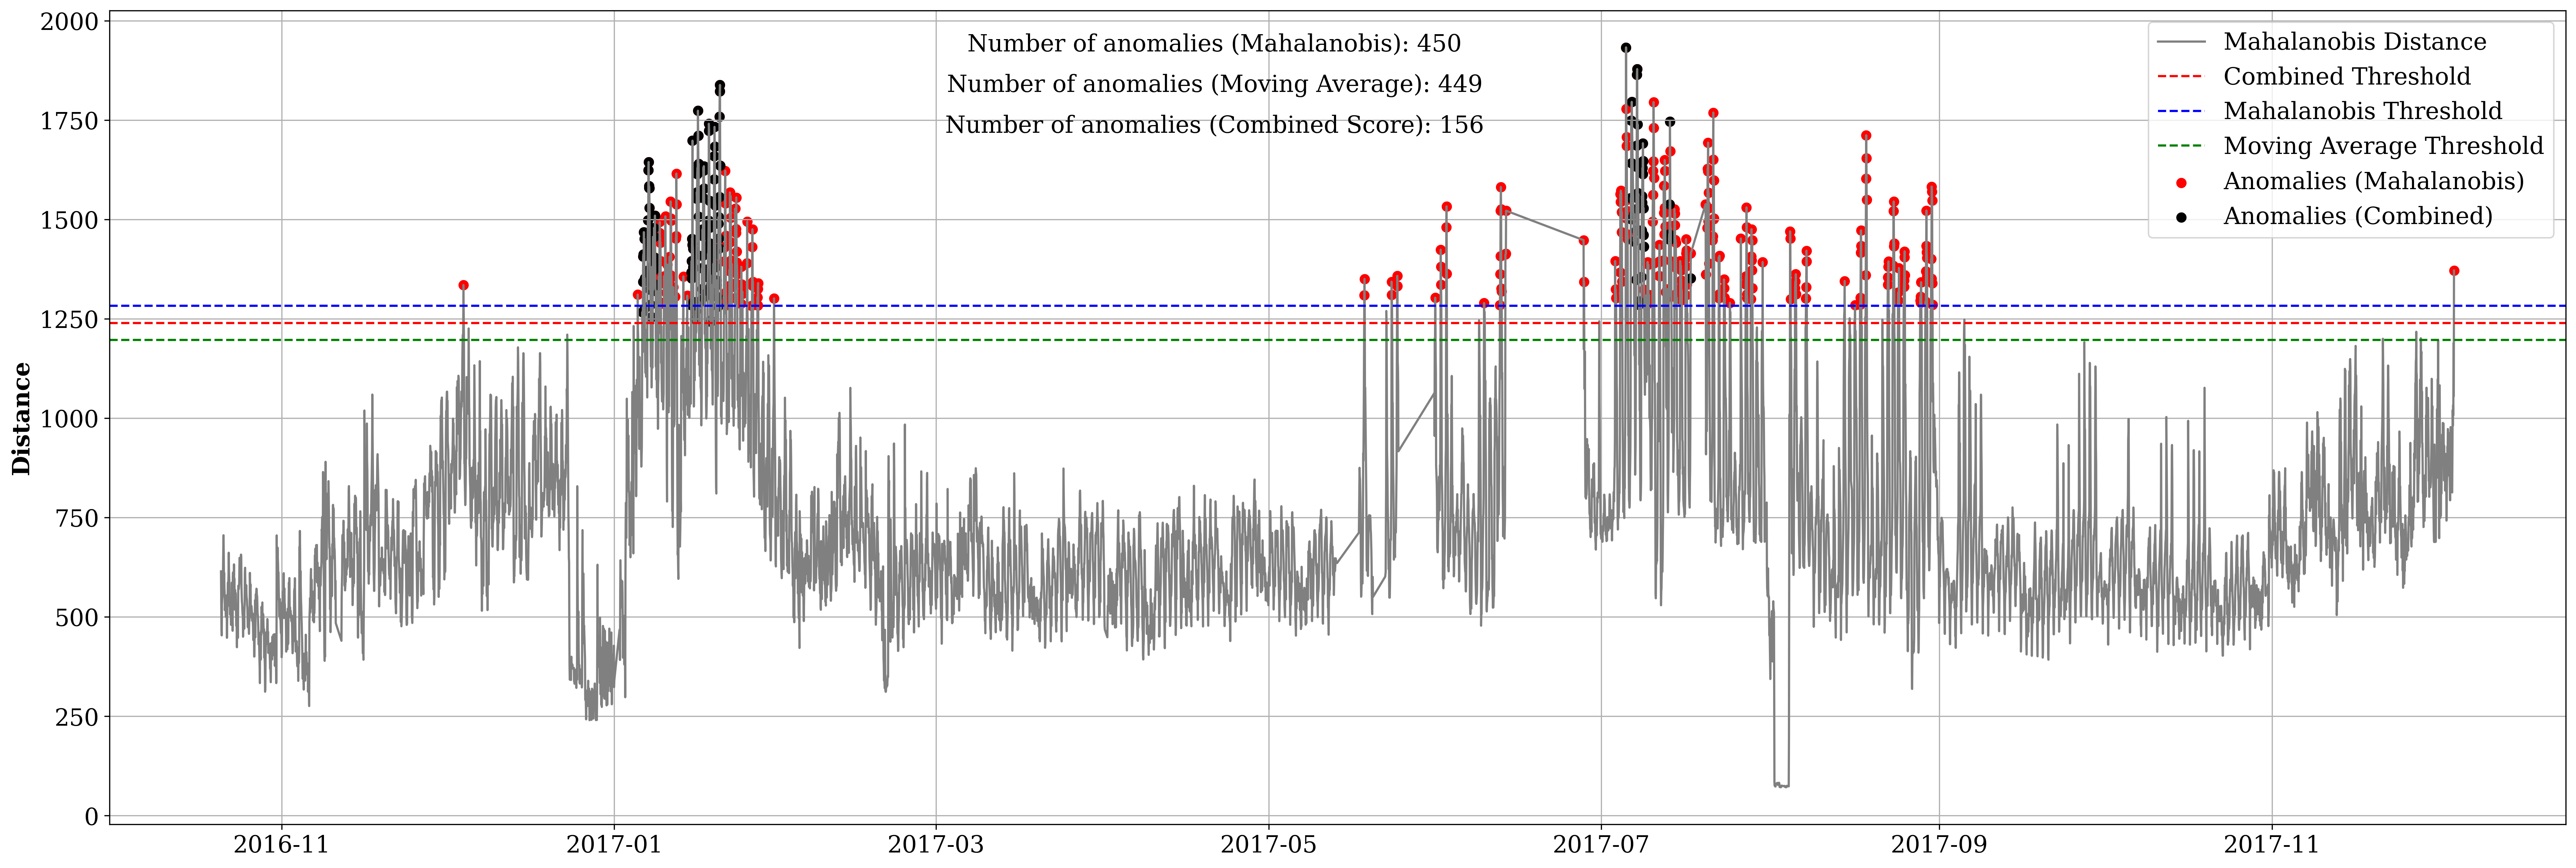

5.612965106964111


In [ ]:
import time
start = time.time()

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

pd.set_option('display.max_columns', 500)

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

X = pd.concat([train, test])
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

X = X[['Timestamp','Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift','tv delta']]
X = X[X['Timestamp'] != '2012-09-20 04:00:00+00:00']
X = X[X['Timestamp'] != '2012-09-20 05:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 09:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 10:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 11:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 12:00:00+00:00']

df = X.copy()


df['month'] = df['Timestamp'].dt.month
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['hour'] = df['Timestamp'].dt.hour
df = df.set_index('Timestamp')
df.sort_index(inplace=True)

X = df[['Temperature', 'holiday', 'prev value', 'twice prev value', 'day shift',
       'month shift', 'month', 'day_of_week', 'hour']]
y = df['tv delta']

X_train = X[:40000]
X_test = X[40000:]
y_train = y[:40000]
y_test = y[40000:]

def mahalanobis_distance(x, mean_vector, cov_matrix):
    delta = x - mean_vector
    mahalanobis_dist = np.sqrt(np.dot(delta, np.dot(np.linalg.inv(cov_matrix), delta.T)))
    return mahalanobis_dist

# LightGBM model
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
train_data = lgb.Dataset(X_train, label=y_train)
bst = lgb.train(params, train_data, num_boost_round=100)

train_pred = bst.predict(X_train)
# predictions on the test data
test_pred = bst.predict(X_test)

# Mahalanobis distance for each predicted value
mean_vector = X_test.mean(axis=0)
cov_matrix = np.cov(X_test, rowvar=False)
mahalanobis_distances = []
for point in test_pred:
    mahalanobis_distances.append(mahalanobis_distance(point, mean_vector, cov_matrix))

# moving averages of Mahalanobis distances
window_size = 24  # Adjust window size as needed
moving_avg_distances = np.convolve(mahalanobis_distances, np.ones(window_size)/window_size, mode='valid')

# dynamic thresholds
mahalanobis_threshold = np.percentile(mahalanobis_distances, 95)
moving_avg_threshold = np.percentile(moving_avg_distances, 95)

anomalies_mahalanobis = (mahalanobis_distances > mahalanobis_threshold).astype(int)
anomalies_moving_avg = (moving_avg_distances > moving_avg_threshold).astype(int)

# Combine Mahalanobis distance and moving averages to determine the threshold
combined_threshold = (mahalanobis_threshold + moving_avg_threshold) / 2

# Ensure both arrays have the same length
min_length = min(len(mahalanobis_distances), len(moving_avg_distances))
mahalanobis_distances = mahalanobis_distances[:min_length]
moving_avg_distances = moving_avg_distances[:min_length]

# Classify anomalies
anomalies_combined = ((mahalanobis_distances > combined_threshold) & (moving_avg_distances > combined_threshold)).astype(int)
date_indices = X_test.index[:min_length]
num_anomalies_combined = np.sum(anomalies_combined)

plt.figure(figsize=(30, 10), dpi=300)
plt.plot(date_indices, mahalanobis_distances, label='Mahalanobis Distance', color='gray')
plt.plot(date_indices, moving_avg_distances, label='Moving Average', color='orange')

# Plot dynamic thresholds
plt.axhline(combined_threshold, color='red', linestyle='--', label='Combined Threshold')
plt.axhline(mahalanobis_threshold, color='blue', linestyle='--', label='Mahalanobis Threshold')
plt.axhline(moving_avg_threshold, color='green', linestyle='--', label='Moving Average Threshold')

# anomaly points for Mahalanobis distances
anomaly_indices_mahalanobis = np.where(anomalies_mahalanobis == 1)[0]
plt.scatter(date_indices[anomaly_indices_mahalanobis], [mahalanobis_distances[i] for i in anomaly_indices_mahalanobis], color='red', label='Anomalies (Mahalanobis)')

# anomaly points for moving averages
anomaly_indices_moving_avg = np.where(anomalies_moving_avg == 1)[0]
plt.scatter(date_indices[anomaly_indices_moving_avg], [moving_avg_distances[i] for i in anomaly_indices_moving_avg], color='purple', label='Anomalies (Moving Average)')

# anomaly points for combined score
anomaly_indices_combined = np.where(anomalies_combined == 1)[0]
plt.scatter(date_indices[anomaly_indices_combined], [mahalanobis_distances[i] for i in anomaly_indices_combined], color='black', label='Anomalies (Combined)')

plt.legend(fontsize=16)
plt.xlabel('Date')
plt.ylabel('Distance', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.annotate(f'Number of anomalies (Mahalanobis): {np.sum(anomalies_mahalanobis)}', xy=(0.45, 0.95), xycoords='axes fraction', ha='center', fontsize=16)
plt.annotate(f'Number of anomalies (Moving Average): {np.sum(anomalies_moving_avg)}', xy=(0.45, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
plt.annotate(f'Number of anomalies (Combined Score): {num_anomalies_combined}', xy=(0.45, 0.85), xycoords='axes fraction', ha='center', fontsize=16)
plt.show()

end = time.time()
print(end-start)

## time series cross validation

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 40830, number of used features: 9
[LightGBM] [Info] Start training from score 131.573780


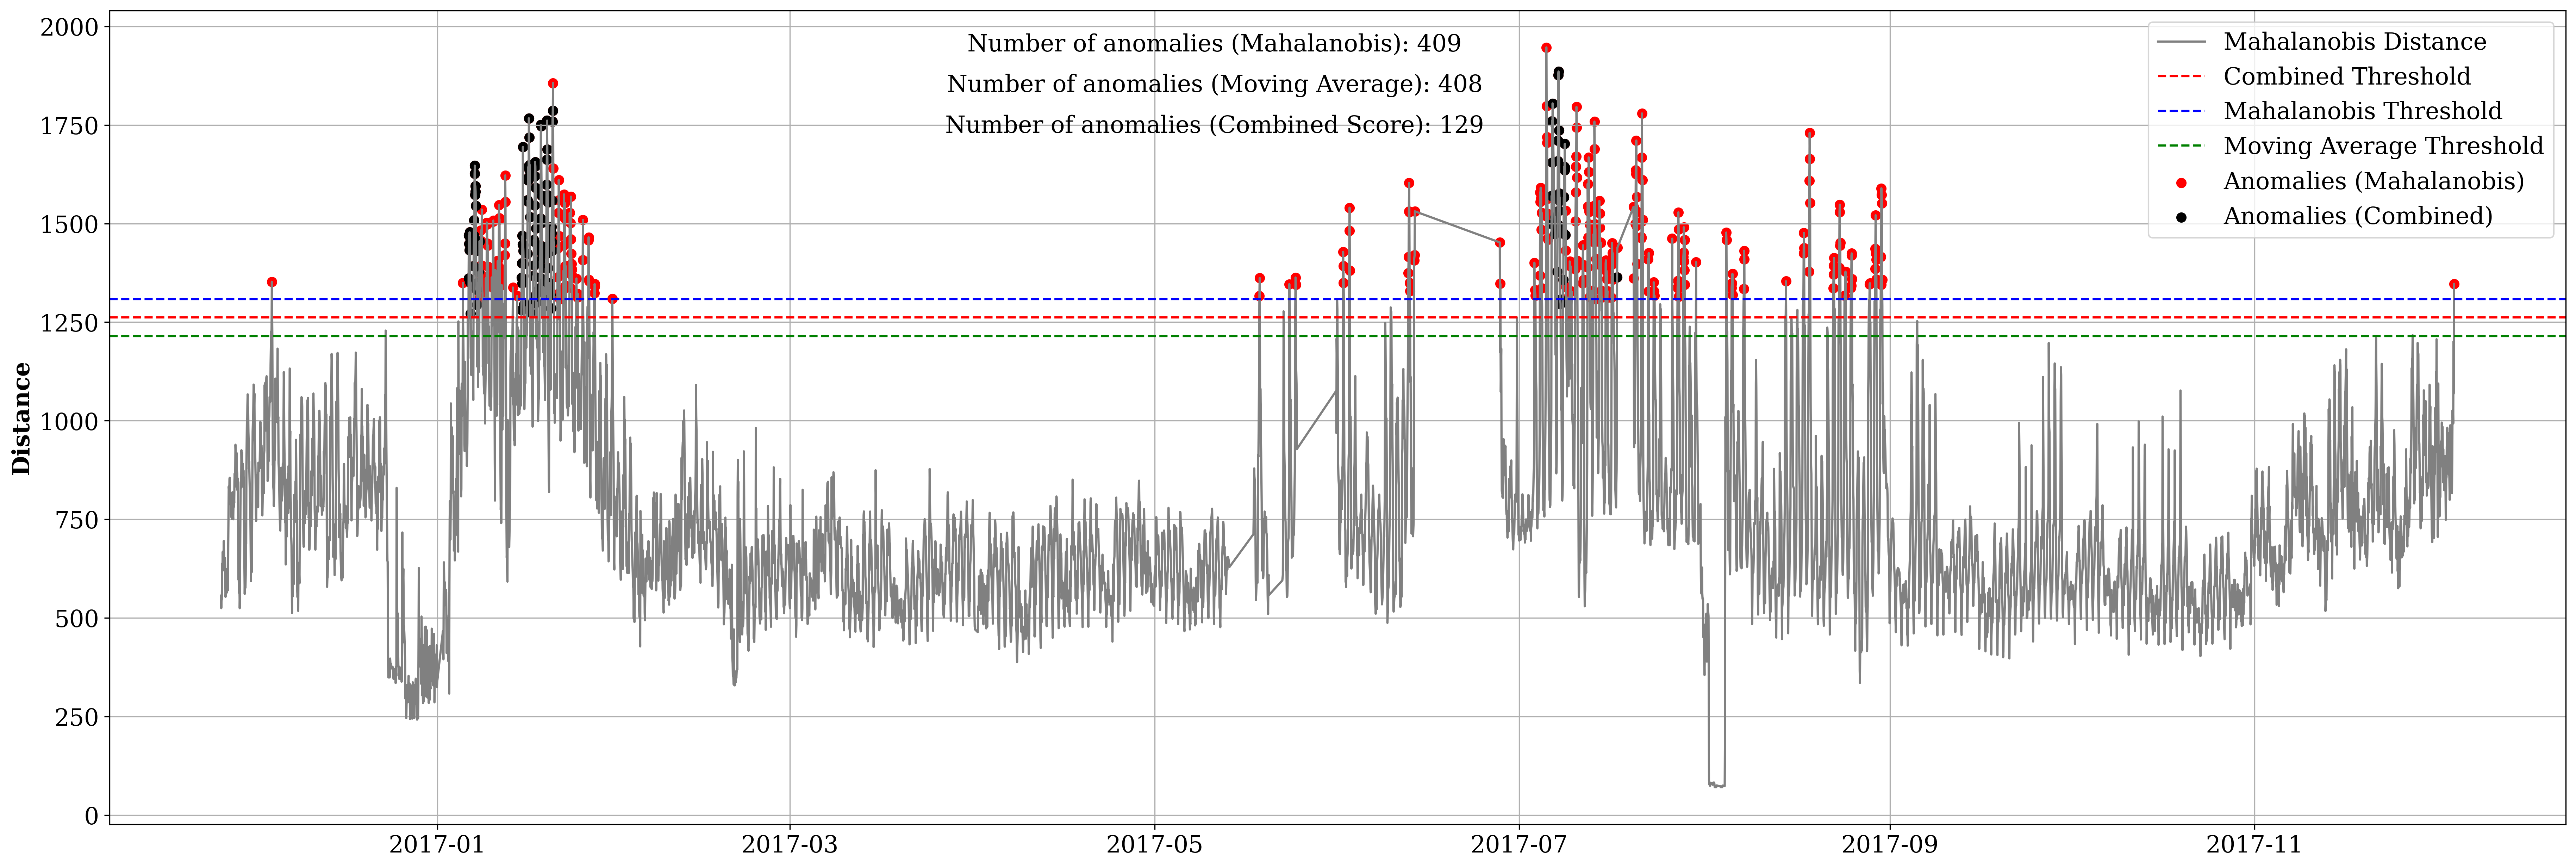

169.9687740802765


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

pd.set_option('display.max_columns', 500)
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

X = pd.concat([train, test])
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

X = X[['Timestamp','Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift','tv delta']]
X = X[X['Timestamp'] != '2012-09-20 04:00:00+00:00']
X = X[X['Timestamp'] != '2012-09-20 05:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 09:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-21 10:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 11:00:00+00:00']
X = X[X['Timestamp'] != '2012-08-20 12:00:00+00:00']

df = X.copy()

df['month'] = df['Timestamp'].dt.month
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['hour'] = df['Timestamp'].dt.hour
df = df.set_index('Timestamp')
df.sort_index(inplace=True)

X = df[['Temperature', 'holiday', 'prev value', 'twice prev value', 'day shift',
       'month shift', 'month', 'day_of_week', 'hour']]
y = df['tv delta']


tscv = TimeSeriesSplit(n_splits=5)

all_predictions = []
all_true_values = []

# time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Mahalanobis Distance
def mahalanobis_distance(x, mean_vector, cov_matrix):
    delta = x - mean_vector
    mahalanobis_dist = np.sqrt(np.dot(delta, np.dot(np.linalg.inv(cov_matrix), delta.T)))
    return mahalanobis_dist

# LightGBM model
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
train_data = lgb.Dataset(X_train, label=y_train)
bst = lgb.train(params, train_data, num_boost_round=100)

train_pred = bst.predict(X_train)
test_pred = bst.predict(X_test)

# Mahalanobis distance for each predicted value
mean_vector = X_test.mean(axis=0)
cov_matrix = np.cov(X_test, rowvar=False)
mahalanobis_distances = []
for point in test_pred:
    mahalanobis_distances.append(mahalanobis_distance(point, mean_vector, cov_matrix))

# moving averages of Mahalanobis distances
window_size = 24  # Adjust window size as needed
moving_avg_distances = np.convolve(mahalanobis_distances, np.ones(window_size)/window_size, mode='valid')

# dynamic thresholds
mahalanobis_threshold = np.percentile(mahalanobis_distances, 95)
moving_avg_threshold = np.percentile(moving_avg_distances, 95)

# Classify anomalies
anomalies_mahalanobis = (mahalanobis_distances > mahalanobis_threshold).astype(int)
anomalies_moving_avg = (moving_avg_distances > moving_avg_threshold).astype(int)

# Combine Mahalanobis distance and moving averages to determine the threshold
combined_threshold = (mahalanobis_threshold + moving_avg_threshold) / 2

min_length = min(len(mahalanobis_distances), len(moving_avg_distances))
mahalanobis_distances = mahalanobis_distances[:min_length]
moving_avg_distances = moving_avg_distances[:min_length]

# Classify anomalies
anomalies_combined = ((mahalanobis_distances > combined_threshold) & (moving_avg_distances > combined_threshold)).astype(int)
date_indices = X_test.index[:min_length]

num_anomalies_combined = np.sum(anomalies_combined)


plt.figure(figsize=(30, 10), dpi=300)
plt.plot(date_indices, mahalanobis_distances, label='Mahalanobis Distance', color='gray')
plt.plot(date_indices, moving_avg_distances, label='Moving Average', color='orange')

# dynamic thresholds
plt.axhline(combined_threshold, color='red', linestyle='--', label='Combined Threshold')
plt.axhline(mahalanobis_threshold, color='blue', linestyle='--', label='Mahalanobis Threshold')
plt.axhline(moving_avg_threshold, color='green', linestyle='--', label='Moving Average Threshold')

# Mark anomaly points for Mahalanobis distances
anomaly_indices_mahalanobis = np.where(anomalies_mahalanobis == 1)[0]
plt.scatter(date_indices[anomaly_indices_mahalanobis], [mahalanobis_distances[i] for i in anomaly_indices_mahalanobis],
            color='red', label='Anomalies (Mahalanobis)')

# Mark anomaly points for moving averages
anomaly_indices_moving_avg = np.where(anomalies_moving_avg == 1)[0]
plt.scatter(date_indices[anomaly_indices_moving_avg], [moving_avg_distances[i] for i in anomaly_indices_moving_avg],
            color='purple', label='Anomalies (Moving Average)')

# Mark anomaly points for combined score
anomaly_indices_combined = np.where(anomalies_combined == 1)[0]
plt.scatter(date_indices[anomaly_indices_combined], [mahalanobis_distances[i] for i in anomaly_indices_combined],
            color='black', label='Anomalies (Combined)')

plt.legend(fontsize=16)
plt.xlabel('Date')
plt.ylabel('Distance', fontsize=16, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Annotate the plot with the number of anomalies
plt.annotate(f'Number of anomalies (Mahalanobis): {np.sum(anomalies_mahalanobis)}', xy=(0.45, 0.95), xycoords='axes fraction', ha='center', fontsize=16)
plt.annotate(f'Number of anomalies (Moving Average): {np.sum(anomalies_moving_avg)}', xy=(0.45, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
plt.annotate(f'Number of anomalies (Combined Score): {num_anomalies_combined}', xy=(0.45, 0.85), xycoords='axes fraction', ha='center', fontsize=16)
plt.show()

end = time.time()
print(end-start)


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

n_bootstrap = 1000

bootstrap_maes = np.zeros(n_bootstrap)

for i in range(n_bootstrap):

    bootstrap_indices = np.random.choice(len(y_test), len(y_test), replace=True)
    y_true_bootstrap = y_test[bootstrap_indices]
    y_pred_bootstrap = test_pred[bootstrap_indices]


    bootstrap_maes[i] = mean_absolute_error(y_true_bootstrap, y_pred_bootstrap)

# confidence intervals
confidence_interval = np.percentile(bootstrap_maes, [2.5, 97.5])

print("95% Confidence Interval for MAE:", confidence_interval)

95% Confidence Interval for MAE: [10.27175411 10.75328172]
